# Import Libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [4]:
# https://www.kaggle.com/datasets/zubairamuti/bmw-car-sales-record-2010-2024
try:
    df = pd.read_csv("BMW sales data (2010-2024).csv")
except FileNotFoundError:
    print("Error! File not found in the directory")
except Excpetion as e:
    print(f"Error: {e}")

# Data Dictionary

In [ ]:
# BMW is a world-renowned German automobile brand known for its combination of luxury, performance, and advanced engineering. 
# Every BMW car is designed to deliver a smooth driving experience with powerful engines, precise handling, and 
# a premium interior that reflects comfort and modern technology. From sporty sedans to high-end SUVs, 
# BMW focuses on innovation, safety, and a dynamic driving feel that attracts car enthusiasts worldwide. 
# Its signature design and strong build quality make BMW one of the most respected names in the automotive industry. 
# This dataset contains records of sales for 15 years from 2010 to 2024. The information includes the sales of the BMW car, 
# its various models in different ranges. From low to high and medium range, all sold models and cars of different colors, each element is included therein, 
# which are necessary to take care of while purchasing a Car.

# 1. Model
# Short: BMW model name (e.g., X3, i8, 5 Series)

# 2. Year
# Short: Manufacturing year of the car.

# 3. Region
# Short: Geographical area where the car was sold.

# 4. Color
# Short: Exterior color of the vehicle.

# 5. Fuel_Type
# Short: Type of fuel used (Petrol/Diesel/Hybrid/Electric).

# 6. Transmission
# Short: Gear type (Automatic or Manual).

# 7. Engine_Size_L
# Short: Engine capacity in liters.

# 8. Mileage_KM
# Short: Total kilometers driven.

# 9. Price_USD
# Short: Selling price of the car in USD.

# 10. Sales_Volume
# Short: Number of units sold in that year.

# 11. Sales_Classification
# Short: Sales category (High or Low).

# EDA

In [6]:
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [7]:
df['Sales_Classification'].value_counts()

Sales_Classification
Low     34754
High    15246
Name: count, dtype: int64

In [8]:
df.shape

(50000, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [10]:
df.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [11]:
df.columns

Index(['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission',
       'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume',
       'Sales_Classification'],
      dtype='object')

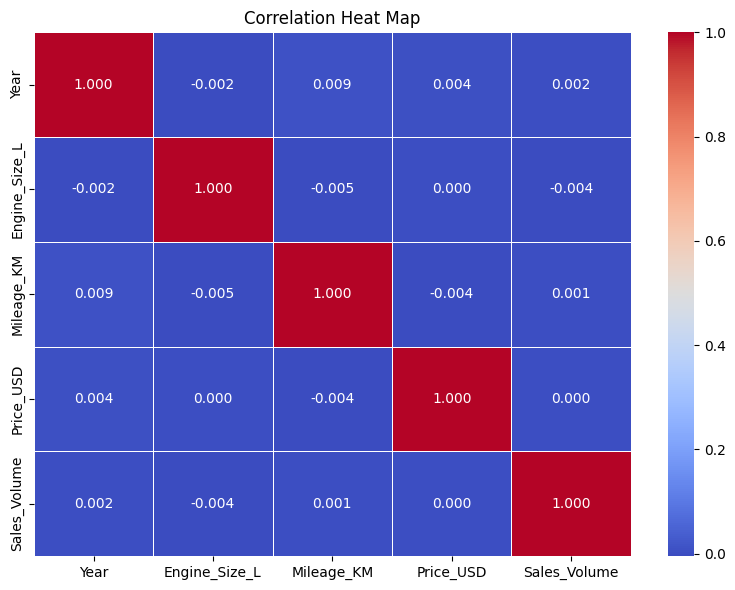

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(data=df.corr(numeric_only=True), annot=True, linewidths=0.5,fmt=".3f",cmap="coolwarm")
plt.title("Correlation Heat Map")
plt.tight_layout()
plt.show()

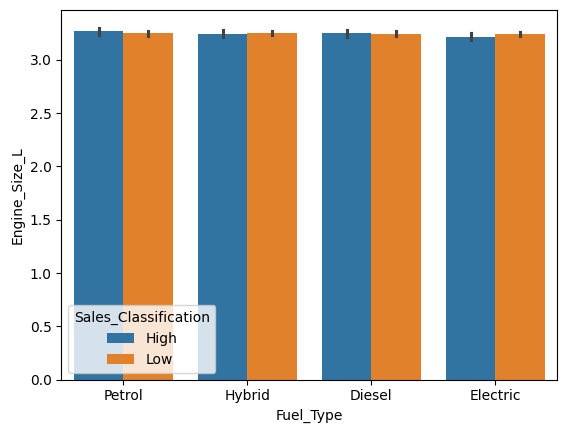

In [13]:
sns.barplot(x=df['Fuel_Type'], y=df['Engine_Size_L'],hue=df['Sales_Classification'])
plt.show()

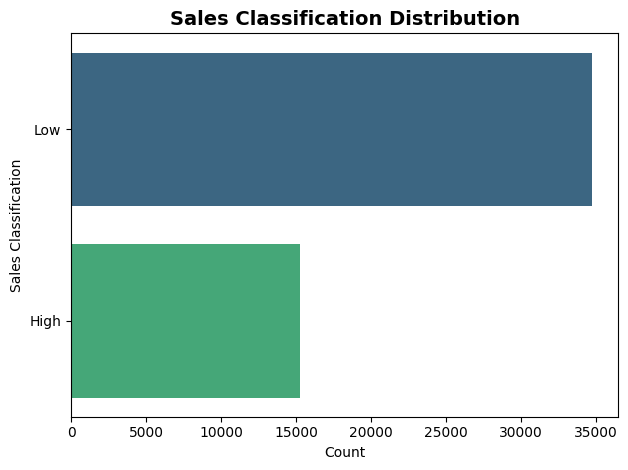

In [14]:
sns.countplot( y=df['Sales_Classification'], order=df["Sales_Classification"].value_counts().index ,palette="viridis")
plt.title("Sales Classification Distribution", fontsize=14, weight="bold")
plt.xlabel("Count")
plt.ylabel("Sales Classification")
plt.tight_layout()
plt.show()

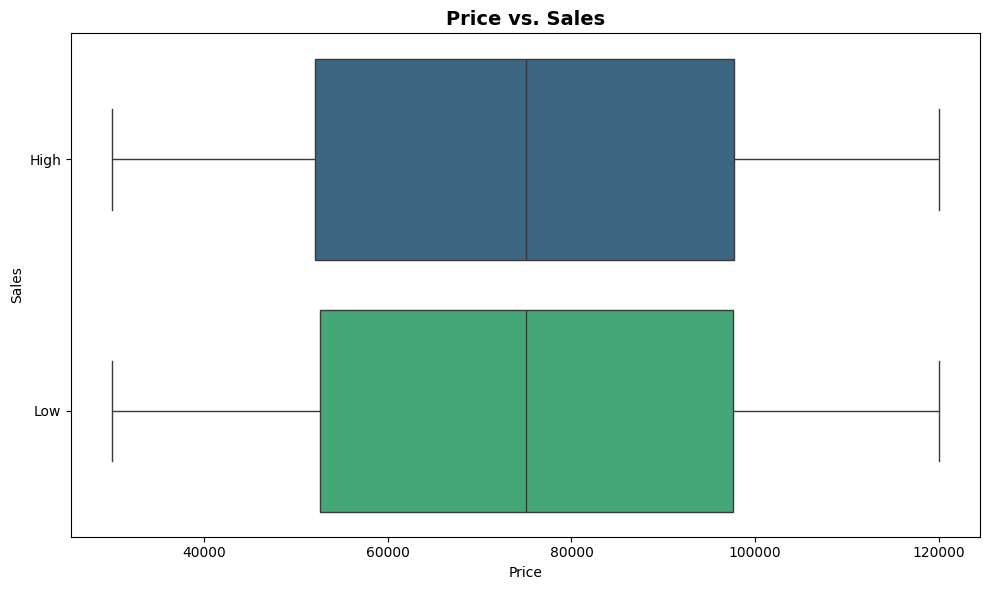

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price_USD'], y=df['Sales_Classification'], palette='viridis')
plt.title('Price vs. Sales', fontsize=14, weight='bold')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

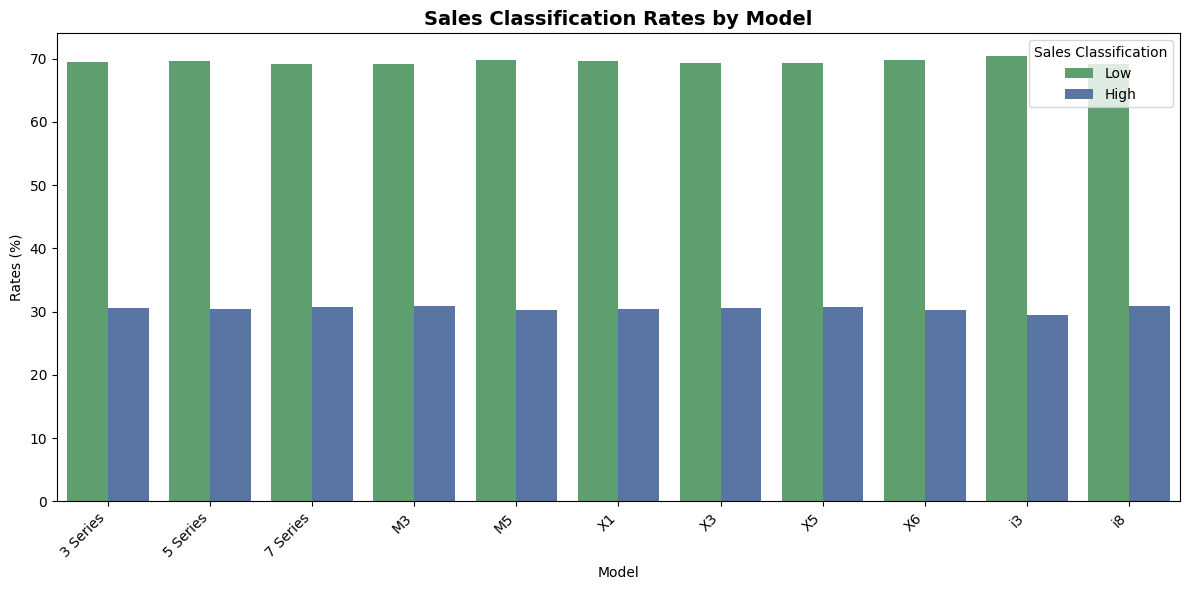

In [16]:
model_sales_proportions = df.groupby('Model')['Sales_Classification'].value_counts(normalize=True).mul(100).rename('Proportion').reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model',
    y='Proportion',
    hue='Sales_Classification',
    data=model_sales_proportions,
    palette={'High': '#4C72B0', 'Low': '#55A868'}
)
plt.title('Sales Classification Rates by Model', fontsize=14, weight='bold')
plt.xlabel('Model')
plt.ylabel('Rates (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sales Classification')
plt.tight_layout()
plt.show()

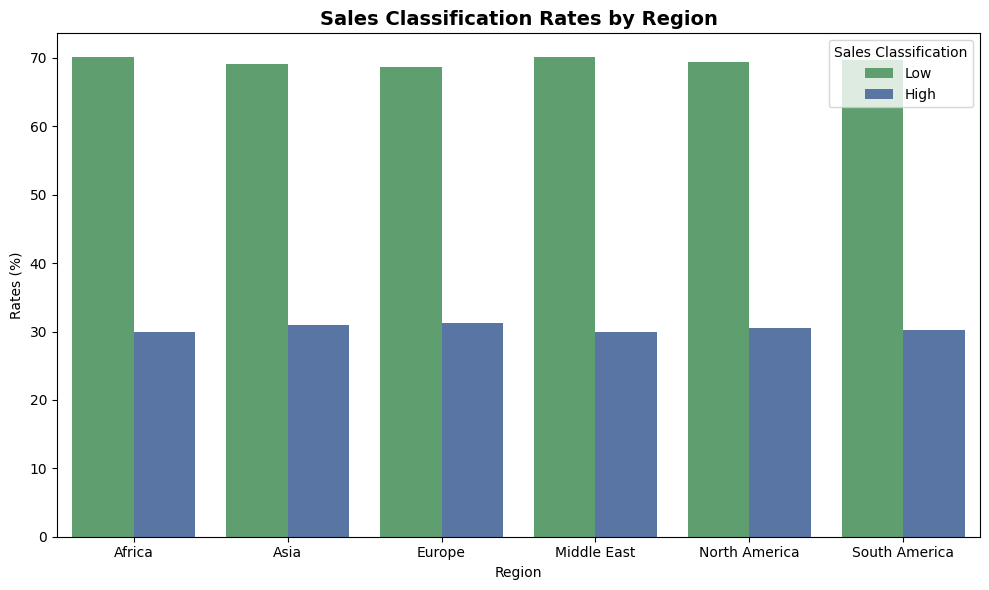

In [17]:
region_sales_proportions = df.groupby('Region')['Sales_Classification'].value_counts(normalize=True).mul(100).rename('Proportion').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Region',
    y='Proportion',
    hue='Sales_Classification',
    data=region_sales_proportions,
    palette={'High': '#4C72B0', 'Low': '#55A868'}
)
plt.title('Sales Classification Rates by Region', fontsize=14, weight='bold')
plt.xlabel('Region')
plt.ylabel('Rates (%)')
plt.legend(title='Sales Classification')
plt.tight_layout()
plt.show()

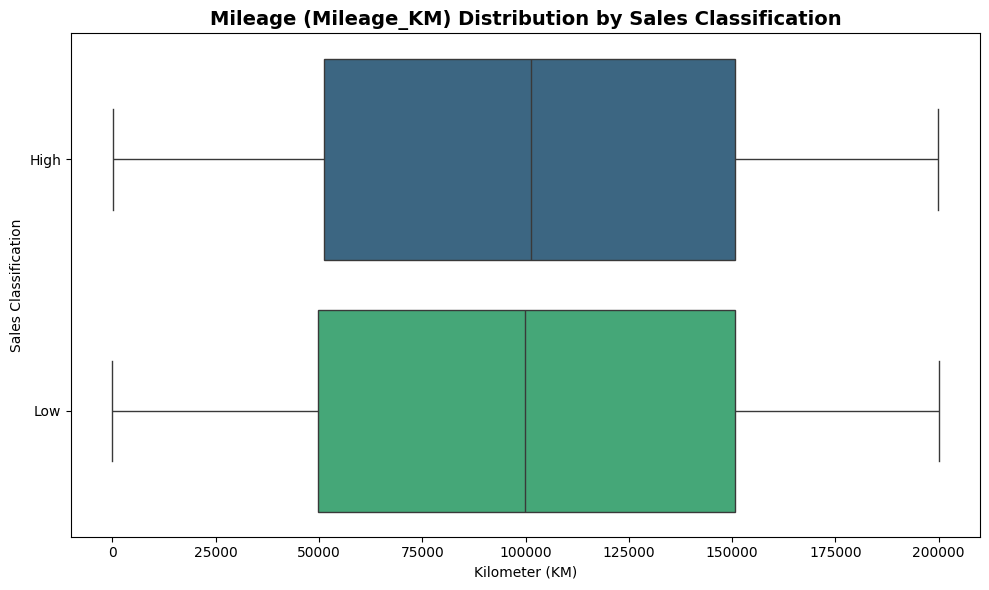

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=df['Mileage_KM'],
    y=df['Sales_Classification'],
    palette='viridis'
)
plt.title('Mileage (Mileage_KM) Distribution by Sales Classification', fontsize=14, weight='bold')
plt.xlabel('Kilometer (KM)')
plt.ylabel('Sales Classification')
plt.tight_layout()
plt.show()

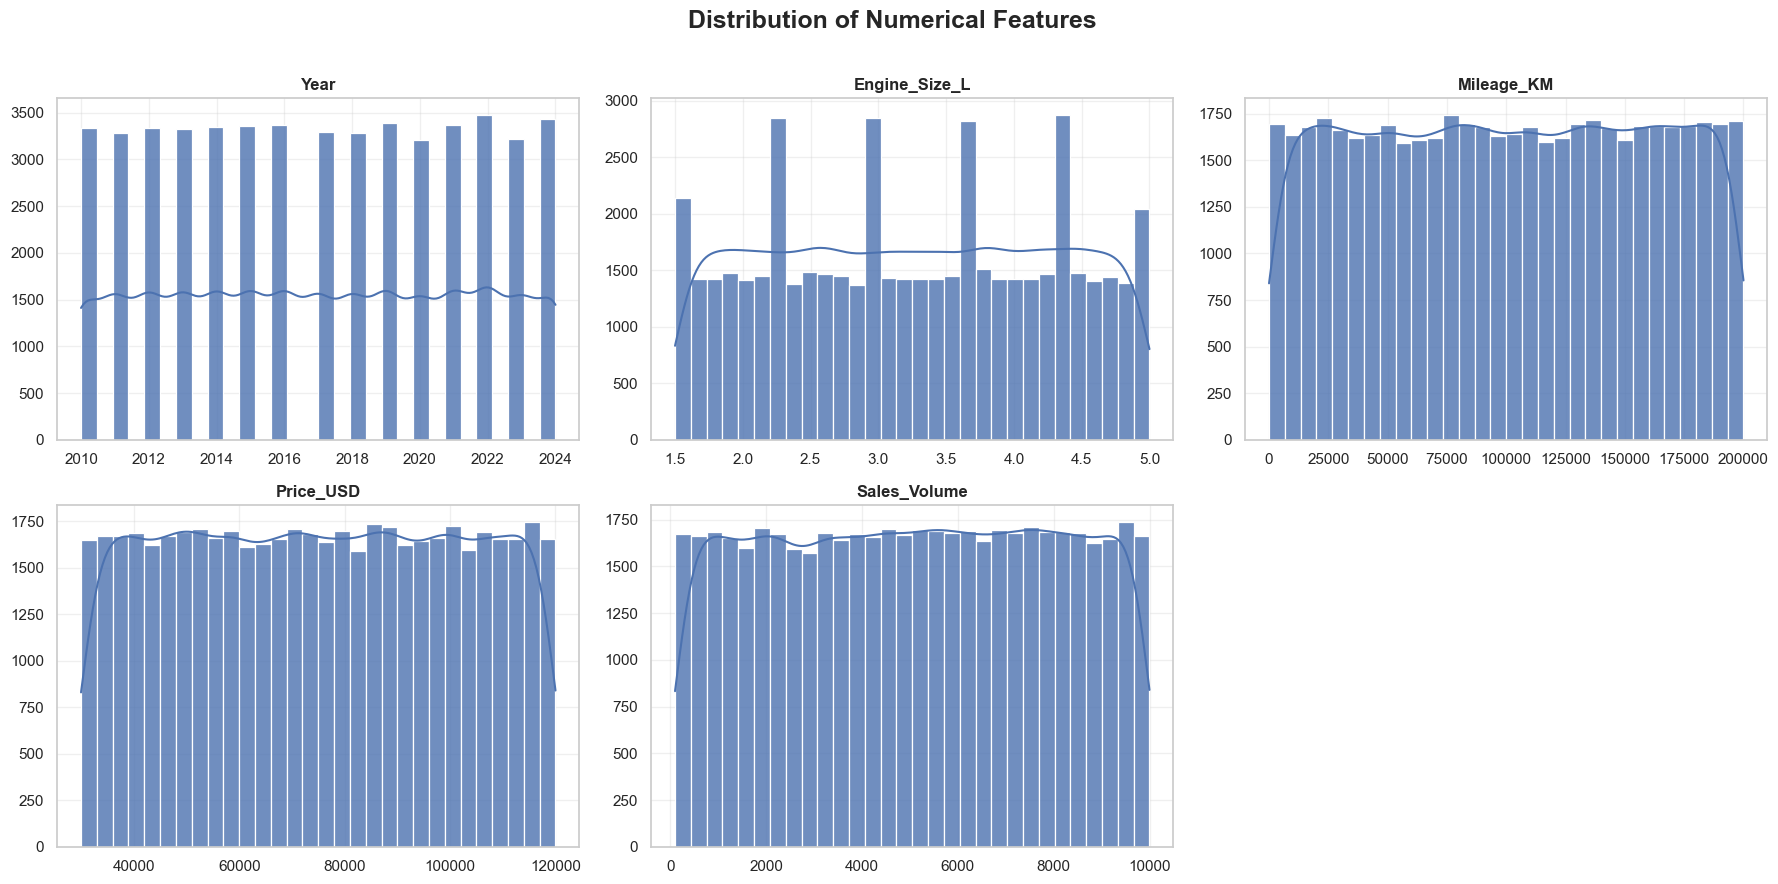

In [19]:
def plot_all_histograms(df, title_prefix=""):
    sns.set_theme(style="whitegrid", palette="crest")

    num_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = math.ceil(len(num_cols) / n_cols)

    plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30, color="#4C72B0", edgecolor="white", alpha=0.8)
        plt.title(f"{title_prefix}{col}", fontsize=12, weight='bold')
        plt.xlabel("")
        plt.ylabel("")
        plt.grid(alpha=0.3)

    plt.suptitle("Distribution of Numerical Features", fontsize=18, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_all_histograms(df)

In [20]:
for col in df.columns:
    print(col)
    print(df[col].unique(), "\t", df[col].nunique())
    print()

Model
['5 Series' 'i8' 'X3' '7 Series' 'M5' '3 Series' 'X1' 'M3' 'X5' 'i3' 'X6'] 	 11

Year
[2016 2013 2022 2024 2020 2017 2014 2019 2012 2015 2011 2021 2023 2010
 2018] 	 15

Region
['Asia' 'North America' 'Middle East' 'South America' 'Europe' 'Africa'] 	 6

Color
['Red' 'Blue' 'Black' 'Silver' 'White' 'Grey'] 	 6

Fuel_Type
['Petrol' 'Hybrid' 'Diesel' 'Electric'] 	 4

Transmission
['Manual' 'Automatic'] 	 2

Engine_Size_L
[3.5 1.6 4.5 1.7 2.1 1.9 1.8 3.  2.4 3.8 2.3 2.6 3.1 3.7 4.8 3.3 3.2 2.2
 4.1 2.  4.7 4.3 4.  3.6 4.9 3.4 2.8 3.9 1.5 4.2 2.5 2.7 4.6 5.  4.4 2.9] 	 36

Mileage_KM
[151748 121671  10991 ... 147396   3379 171003] 	 44347

Price_USD
[ 98740  79219 113265 ...  73173  48714  77492] 	 38246

Sales_Volume
[8300 3428 6994 ... 8743 4398 4341] 	 9845

Sales_Classification
['High' 'Low'] 	 2



In [21]:
# FIND MULTICOLİNEARİTY
def correlation_for_dropping(df, threshold):
    columns_to_drop = set()
    corr = df.corr(numeric_only=True)
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                colname = corr.columns[i]
                columns_to_drop.add(colname)
    return columns_to_drop

print(correlation_for_dropping(df, 0.8))

set()


In [22]:
label_encoder = LabelEncoder()
df['Transmission'] = label_encoder.fit_transform(df['Transmission'])

# Define dependent & independent Features and Train-Test Split

In [24]:
X = df.drop(["Sales_Classification","Sales_Volume"],axis=1)
y = df['Sales_Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

# Preprocessing

In [26]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [27]:
cols_to_encode = X_train.select_dtypes(exclude=["number"]).columns
cols_to_scale = [col for col in X_train.columns if X_train[col].dtypes != "object" and col !="Transmission"]

preprocessor = ColumnTransformer([
    ("Scaler",StandardScaler(),cols_to_scale),
    ("OneHotEncoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False),cols_to_encode)
],remainder="passthrough")

# Build Pipeline

In [29]:
model = XGBClassifier(n_jobs=-1,scale_pos_weight=2.28)
# Weighting:You can increase the weight of the positive class (e.g., ‘High’) by adding scale_pos_weight to the model parameters. roughly, the weight ratio 
# Number of Negative Examples / Number of Positive Examples = 34754/15246 approx 2.28 may be. 

Use this value as scale_pos_weight=2.28 or include this parameter in RandomizedSearchCV.

pipeline = Pipeline([
    ("preprocessor",preprocessor),
    ("model",model)
])

pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)

print("Accuracy: ",accuracy_score(y_test,y_pred))
print()
print(classification_report(y_test,y_pred))
print()
print(confusion_matrix(y_test,y_pred))

Accuracy:  0.69472

              precision    recall  f1-score   support

           0       0.33      0.01      0.01      3787
           1       0.70      0.99      0.82      8713

    accuracy                           0.69     12500
   macro avg       0.51      0.50      0.42     12500
weighted avg       0.58      0.69      0.58     12500


[[  27 3760]
 [  56 8657]]


# Hyper Parameter Tuning

In [31]:
xgboost_params = {
    "model__n_estimators" : [100, 200, 300, 500],
    "model__max_depth" : [3, 5, 7, 12, 15],
    "model__learning_rate" : [0.001, 0.01, 0.1],
    "model__subsample" : [0.8, 1],
    "model__colsample_bytree" : [0.8, 1],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__gamma": [0, 0.1, 0.3, 1],
    "model__reg_alpha": [0, 0.01, 0.1],
    "model__reg_lambda": [1, 2, 5]
}

random_xgb = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xgboost_params,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_iter=20,
    n_jobs=-1,
    random_state=15
)

random_xgb.fit(X_train,y_train)

best_xgb = random_xgb.best_estimator_
print("Parameters: ",)
print(random_xgb.best_params_,"\n")

y_pred_test = random_xgb.predict(X_test)

print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

y_pred_train = random_xgb.predict(X_train)

print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameters: 
{'model__subsample': 1, 'model__reg_lambda': 5, 'model__reg_alpha': 0.01, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 15, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 0.8} 

Test Accuracy:  0.69704
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3787
           1       0.70      1.00      0.82      8713

    accuracy                           0.70     12500
   macro avg       0.35      0.50      0.41     12500
weighted avg       0.49      0.70      0.57     12500

[[   0 3787]
 [   0 8713]]
Train Accuracy:  0.6944266666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11459
           1       0.69      1.00      0.82     26041

    accuracy                           0.69     37500
   macro avg       0.35      0.50      0.41     37500


# Taking the Model Outside

In [60]:
with open("best_xgboost_pipeline.pkl","wb") as file:
    pickle.dump(pipeline, file)